##### Arturo Perez 
##### Professor Koutsoukos 
##### CS 3891 Assignment 4
##### 1 March 2018 

## Preprocessing 
###### In this section we take care of preprocessing the MNIST data set.
We start by reading in the MNIST data set. We seperate the training and testing data into four buffers.

In [48]:
import os, sys
import numpy as np
import struct
import logging
from scipy.special import expit
import matplotlib.pyplot as plt
from mnist import MNIST


# the training set is stored in this directory
path = "/Users/Arturo1/Desktop/Vanderbilt/2017-2018/Spring 2018/Deep Learning 3891/handwriting"

# load the MNIST data
mndata = MNIST(path)
train_images, train_labels = mndata.load_training() # training data
test_images, test_labels = mndata.load_testing() # testing data

We continue by reshaping/rescaling the images and labels of both the training and test data.

In [49]:
# convert to (28x28,1) column vector and divide by 255
training_size, test_size = 60000, 10000   

train_images = np.array(train_images[:training_size], dtype=float).transpose() / 255
train_labels = np.array(train_labels[:training_size], dtype=float)
test_images = np.array(test_images[:test_size], dtype=float).transpose() / 255
test_labels = np.array(test_labels[:test_size], dtype = float)
train_labels = np.reshape(train_labels, (training_size, 1))
test_labels = np.reshape(test_labels, (test_size, 1))

Because we want to predict whether a new image is equal to ID or not, we change the labels from train_labels and test_labels to be either 1 if they are equal to ID, or 0 if they are not. This will help us make our predictions later on and calculate the accuracy/error rates. In my case, ID is equal to 6. 

In [50]:
# student ID
ID = 6
# change the labels to either 0 or 1
def relabel(label):
    for l in label:
        if (l[0] == ID):
            l[0] = 1
        else:
            l[0] = 0
            
relabel(train_labels)
relabel(test_labels)

We complete preprocessing by creating smaller training sets of the training set for later use.

In [61]:
# creating smaller data sets of differing size and differing data
# subset1 of 10 samples
subsetOneImages = train_images[:,:10]
ID_labels1 = train_labels[:10,:]

# subset2 of 75 samples
subsetTwoImages = train_images[:,25:100]
ID_labels2 = train_labels[25:100,:]

# subset 3 of 1,000 samples
subsetThreeImages = train_images[:,200:1200]
ID_labels3 = train_labels[200:1200,:]

# subset 4 of 10,000 samples
subsetFourImages = train_images[:,10000:20000]
ID_labels4 = train_labels[10000:20000,:]

train_images = subsetFourImages
train_labels = ID_labels4

## Learning
###### In this section we use the vectorized implementation of the L layer Neural Network, plot the learning curve, and investigate the impact of the learning rate, sample sizes, and the number of hidden units.

Vectorized implementation of Logistic Gradient Descent with L layers. LGD function will also plot cost curve. The equations used respectively: 

###### Forward Propogation 
$z^{[L]} = w^{[L]}A^{[L-1]} + b^{[L]}$

$A^{[L]} = tanh(z^{[L]})$

$A^{[L]} = ReLU(z^{[L]}) $ (used for the last layer)

###### Backward Propogation 
$dZ^{[L]} = dA^{[L]} * g^{[L]'}(Z^{[L]}) $

$dW^{[L]} = {1 \over m} dZ^{[L]} A^{[L-1]T} $

$dB^{[L]} = {1 \over m} sum horizontally(dZ^{[L]}) $

$dA^{[L-1]} = w^{[L]T} dZ^{[L]} $

###### Cost Function
$J(w,b) = -{1 \over m} \sum\limits_{1=1}^{m} (y log(a[L-1]) + (1 - y)log(1 - a[L-1]) $
###### Update Parameters

$ w = w - \alpha dW $

$ b = b - \alpha dB $

where $\alpha$ is the learning rate 

In [83]:
def ReLU (array):
    return np.maximum(array,0)
    
def dReLU(array):
    return (array >= 0).astype(np.float64)

def LGD(samples, X, y, alpha, layer_list):
    
    
    
    l = len(layer_list)
    m = X.shape[1]
    costs = []
    w  = [0] * (l)
    b  = [0] * (l)
    z  = [0] * (l)
    a  = [0] * (l)
    dZ = [0] * (l)
    dW = [0] * (l)
    dB = [0] * (l)
    dA = [0] * (l)
    #weight initialization
    for i in range(1, l):
        w[i] = np.random.randn(layer_list[i], layer_list[i - 1]) / 1000
        b[i] = np.random.randn(layer_list[i], 1) / 1000
        z[i] = np.zeros((layer_list[i], m))
        a[i] = np.zeros((layer_list[i], m))
        dZ[i] = np.zeros((layer_list[i], m))
        dW[i] = np.zeros((layer_list[i], layer_list[i - 1]))
        dB[i] = np.zeros((layer_list[i], 1))
        dA[i] = np.zeros((layer_list[i], m))
    dA[0] = np.zeros((layer_list[0], m))
    a[0] = X 
    
    
    
    for i in range(0, 500):
        
        
        
        # forward propopgation
        for j in range (1, l):
            z[j] = (w[j] @ a[j-1]) + b[j]
            a[j] = ReLU(z[j])
        a[l-1] = expit(z[l-1]) #sigmoid activation function for last layer

        
        
        #compute cost
        cost = 0
        cost = (np.nan_to_num(
            -y @ np.log(a[l-1]) - (1 - y) @ np.log(1 - a[l-1]))[0, 0] / m)
        costs.append(cost)

        
        
        #backward propogation 
        dA[-1] = - (y.T @ np.log(a[-1].T) + (1 - y.T) @ np.log(1 - a[-1].T))
        for k in range(l-1, 0, -1):
            dZ[k] = dA[k] * dReLU(z[k])
            dW[k] = dZ[k] @ a[k-1].transpose() / m      
            dB[k] = dZ[k].sum(axis = 1).reshape(dB[k].shape[0], dB[k].shape[1]) / m
            dA[k - 1] = w[k].T @ dZ[k]

            
            
        #update parameters 
        for j in range (1, l):
            w[j] = w[j] - (alpha * dW[j])
            b[j] = b[j] - (alpha * dB[j])
            

            
    # plot cost function
    plt.plot(costs)
    plt.title("Student ID Cost Function (" + str(samples) + " samples)")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Cost")
    plt.show()
    return(w, b)


misclassified = []
misclassifiedTag = []
def checkAccuracy(w,b) :
    a = test_images
    z = None

    # forward propopgation 
    for j in range (1, len(layers)):
        z = w[j] @ a + b[j]
        a = ReLU(z)
    a = expit(z)

    count = 0
    result = np.where(a >= 0.5, 1.0, 0.0)
    for i in range(1,10000):
        if result[0, i] == test_labels[i,0]:
            count += 1
        else:
            misclassified.append(i)
        
    accuracy = (count/test_labels.shape[0]) * 100
    error_rate = 100 - accuracy

    print("accuracy for ID = " + str(ID) + " is : " + str(accuracy) + "%")
    print("error rate for ID = " + str(ID) + " is : " + str(error_rate) + "%")

## Evaluation

We will now train the model with varying sample sizes, number of layers, number of units in each hidden layer, and adjusting the learning rate alpha.

#### Full Disclaimer 

I spent many hours working on and debugging this project, but in the end I could not figure out all of my bugs. Here are the results of my code.

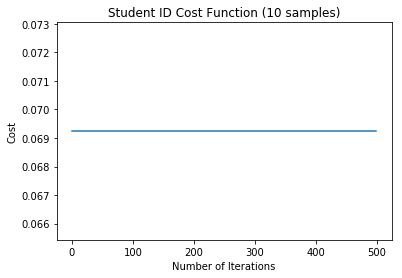

accuracy for ID = 6 is : 90.41%
error rate for ID = 6 is : 9.590000000000003%


In [53]:
layers = [784, 20, 10, 1] #3 layers with 20, 10, and 1 hidden units respectively
w,b = LGD(10, subsetOneImages, ID_labels1, .05, layers) #10 samples, alpha = .05
checkAccuracy(w,b)

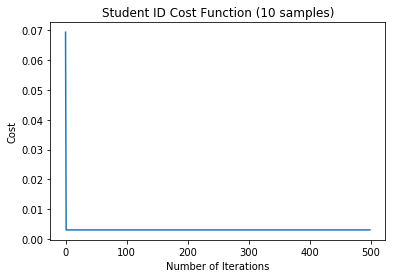

accuracy for ID = 6 is : 90.41%
error rate for ID = 6 is : 9.590000000000003%


In [54]:
layers = [784, 20, 15, 10, 1] #4 layers with 20, 15, 10, 1 hidden units respectively 
w,b = LGD(10, subsetOneImages, ID_labels1, .5, layers) #10 samples, alpha = .5
checkAccuracy(w,b)

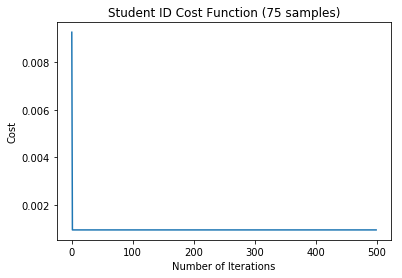

accuracy for ID = 6 is : 90.41%
error rate for ID = 6 is : 9.590000000000003%


In [55]:
layers = [784, 20, 10, 1] #3 layers with 20, 10, and 1 hidden units respectively
w,b = LGD(75, subsetTwoImages, ID_labels2, .05, layers) #75 samples, alpha = .05
checkAccuracy(w,b)

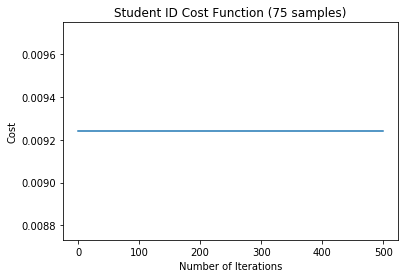

accuracy for ID = 6 is : 90.41%
error rate for ID = 6 is : 9.590000000000003%


In [56]:
layers = [784, 20, 15, 10, 1] #4 layers with 20, 15, 10, and 1 hidden units respectively
w,b = LGD(75, subsetTwoImages, ID_labels2, .5, layers) #75 samples, alpha = .5
checkAccuracy(w,b)

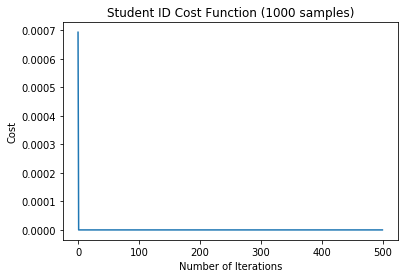

accuracy for ID = 6 is : 90.41%
error rate for ID = 6 is : 9.590000000000003%


In [57]:
layers = [784, 20, 15, 10, 1] #4 layers with 20, 15, 10 and 1 hidden units respectively
w,b = LGD(1000, subsetThreeImages, ID_labels3, .05, layers) #1000 samples, alpha = .05
checkAccuracy(w,b)

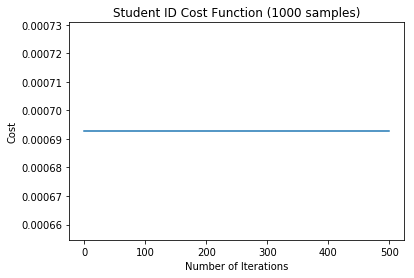

accuracy for ID = 6 is : 90.41%
error rate for ID = 6 is : 9.590000000000003%


In [85]:
layers = [784, 20, 10, 1] #3 layers with 20, 15, 10, and 1 hidden units respectively
w,b = LGD(1000, subsetThreeImages, ID_labels3, .5, layers) #1000 samples, alpha = .5
checkAccuracy(w,b)

In [69]:
# load unflattened mnist images to display
path = "/Users/Arturo1/Desktop/Vanderbilt/2017-2018/Spring 2018/Deep Learning 3891/handwriting"   # the training set is stored in this directory
fname_test_images = os.path.join(path, 't10k-images-idx3-ubyte')  # the training set image file path
fname_train_labels = os.path.join(path, 't10k-labels-idx1-ubyte')  # the training set label file path
    
with open(fname_train_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    testlabels = np.fromfile(flbl, dtype=np.uint8)

with open(fname_test_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    testimages = np.fromfile(fimg, dtype=np.uint8).reshape(len(testlabels), rows, cols)  

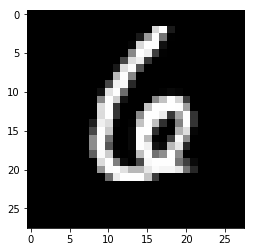

MISCLASSIFIED - THIS IS A 6


In [100]:
plt.imshow(testimages[misclassified[11]], cmap='gray')  # plot the image in "gray" colormap
plt.show()
print("MISCLASSIFIED - THIS IS A 6")

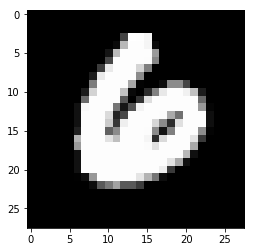

MISCLASSIFIED - THIS IS A 6


In [101]:
plt.imshow(testimages[misclassified[27]], cmap='gray')  # plot the image in "gray" colormap
plt.show()
print("MISCLASSIFIED - THIS IS A 6")

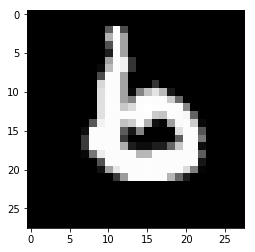

MISCLASSIFIED - NOT A 6


In [99]:
plt.imshow(testimages[misclassified[50]], cmap='gray')  # plot the image in "gray" colormap
plt.show()
print("MISCLASSIFIED - THIS IS A 6")